In [1]:
import os, glob
from sklearn.utils import shuffle
import tensorflow as tf

from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img, array_to_img
import PIL
from PIL import ImageOps
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
#from compose.build.util import processor
from util import processor
import matplotlib.pyplot as plt
import os,glob
import numpy as np
from tqdm import tqdm
from tensorflow import keras
import segmentation_models as sm
from cfg import *
from tqdm import tqdm
import cv2 as cv

sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


Using TensorFlow backend.


In [3]:
BACKBONE = 'inceptionresnetv2'
IMAGE_SIZE=512
CHANNEL=3
n_classes=1
activation='sigmoid'
from model import *
clf_mdl = build_clf_model(n_classes)
seg_mdl = build_seg_model()
seg_tumor_mdl = build_seg_model()

In [4]:
clf_mdl.load_weights('./data/model/clf_0706.hdf5')
#clf_mdl.load_weights('./model/clf_0628.hdf5')
seg_mdl.load_weights('./data/model/seg_nerve_0722_inceptionresnetv2_all.hdf5')
seg_tumor_mdl.load_weights('./data/model/seg_tumor_0721_inceptionresnetv2.hdf5')

./validation/Pan_PNI2021chall_validation_0005.tiff


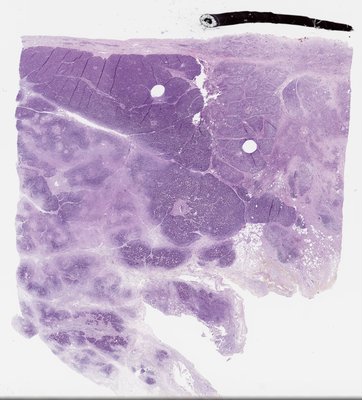

In [5]:
#for svs_path in glob.glob('../../data/valid_paip/*/*.svs')[4:]:
init_params.update(
    {
        'svs_path':'../../data/valid_paip/pan/Pan_PNI2021chall_validation_0005.svs',
        #'svs_path':'../../data/paip/col/Col_PNI2021chall_train_0017.svs',
        'xml_path':'../../new_data/paip/col/Col_PNI2021chall_train_0017.xml'
        
    }
)
save_path = './validation/'+init_params['svs_path'].split('/')[-1][:-4]+'.tiff'
print(save_path)
slide = processor(init_params)
slide.slide.get_thumbnail(size=(400,400))

## INFERENCE ONE

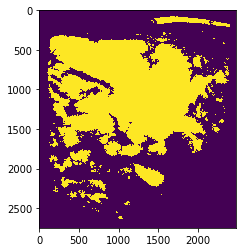

In [8]:
tissue_mask = slide.get_tissue_mask()
mask = np.zeros((slide.dest_h,slide.dest_w))
counter = np.zeros_like(mask)
tissue_mask = cv.morphologyEx(tissue_mask,cv.MORPH_OPEN,cv.getStructuringElement(cv.MORPH_RECT,(5,5)),iterations=1)
plt.imshow(tissue_mask)

In [16]:
#anno_mask = slide.get_anno_mask(tool='asap',show=True)

In [9]:
x = 0; y = 0; 

min_y , min_x = slide.arr.shape[:2]
max_x , max_y = (0,0)


coord = np.where(tissue_mask>0)
if np.min(coord[1])<min_x: min_x = np.min(coord[1])
if np.max(coord[1])>max_x: max_x = np.max(coord[1])
if np.min(coord[0])<min_y: min_y = np.min(coord[0])
if np.max(coord[0])>max_y: max_y = np.max(coord[0])

print(f'MIN_X : {min_x} MIN_Y : {min_y} MAX_X : {max_x} MAX_Y : {max_y}')
'''
for key in anno_mask.keys():
    coord = np.where(anno_mask[key]>0)
    if np.min(coord[1])<min_x: min_x = np.min(coord[1])
    if np.max(coord[1])>max_x: max_x = np.max(coord[1])
    if np.min(coord[0])<min_y: min_y = np.min(coord[0])
    if np.max(coord[0])>max_y: max_y = np.max(coord[0])
print(f'MIN_X : {min_x} MIN_Y : {min_y} MAX_X : {max_x} MAX_Y : {max_y}')
'''

MIN_X : 103 MIN_Y : 79 MAX_X : 2417 MAX_Y : 2641


"\nfor key in anno_mask.keys():\n    coord = np.where(anno_mask[key]>0)\n    if np.min(coord[1])<min_x: min_x = np.min(coord[1])\n    if np.max(coord[1])>max_x: max_x = np.max(coord[1])\n    if np.min(coord[0])<min_y: min_y = np.min(coord[0])\n    if np.max(coord[0])>max_y: max_y = np.max(coord[0])\nprint(f'MIN_X : {min_x} MIN_Y : {min_y} MAX_X : {max_x} MAX_Y : {max_y}')\n"

In [10]:
slide_w = max_x-min_x; slide_h = max_y-min_y; step = 1; multiple = slide.src_h//slide.dest_h
patch_size = 512; patch_size_lv0 = 2*patch_size;  patch_size_lv2 = patch_size_lv0//multiple
#size_patch_lv0_mpp,mpp_val = slide.get_size4mpp(512*4,0.5)
print(f'PATCH_0_SIZE : {patch_size_lv0} PATCH_2_SIZE : {patch_size_lv2} ')
s = int(patch_size_lv0*step)
y_seq,x_seq = slide.get_seq_range(slide_w,slide_h,multiple,patch_size_lv0,s)

  0%|          | 0/40 [00:00<?, ?it/s]

PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


plt.imshow(anno_mask['p_2'][1500:1700,1500:1700])
squeezed = np.squeeze(pred_mask)
plt.figure(); plt.imshow(squeezed)
squeezed_filter = np.where(squeezed>0.5,1,0)
plt.figure(); plt.imshow(squeezed_filter)

uint8 255


/home/centos/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


NameError: name 'anno_mask' is not defined

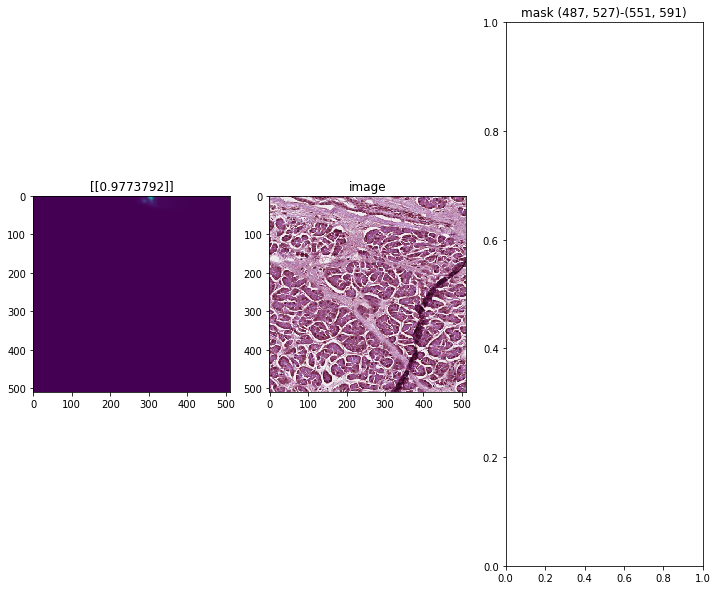

In [12]:
x =6 ;y = 7
start_x = int(min_x+(s*x/multiple)); end_x = int(min_x+((s*(x+int(1/step)))/multiple))
start_y = int(min_y+(s*y/multiple)); end_y = int(min_y+((s*(y+int(1/step)))/multiple))
img_patch = np.array(slide.slide.read_region(
            location=(int((min_x*multiple)+(s*x)),
                      int((min_y*multiple)+(s*y))),
            level=0, size = (patch_size_lv0,patch_size_lv0)   
        )).astype(np.uint8)[...,:3]
img_patch_resized = cv.resize(img_patch,(IMAGE_SIZE,IMAGE_SIZE),cv.INTER_CUBIC)
img_patch_rgb = cv.cvtColor(img_patch_resized,cv.COLOR_BGR2RGB)
pred_val = clf_mdl.predict(np.expand_dims(img_patch_rgb.astype(np.float32)/255.0,axis=0))
pred_mask = seg_mdl.predict(np.expand_dims(img_patch_rgb,axis=0))
if pred_val>0.7:
    print(img_patch_rgb.dtype,np.max(img_patch_rgb))
plt.figure(figsize = (12,10))
plt.subplot(1,3,1)
plt.title(pred_val)
plt.imshow(np.squeeze(pred_mask),vmin=0,vmax=1)
plt.subplot(1,3,2)
plt.title('image')
plt.imshow(img_patch_rgb)
plt.subplot(1,3,3)
plt.title(f'mask {(start_x,start_y)}-{end_x,end_y}')
plt.imshow(anno_mask['p_2'][start_y:end_y,start_x:end_x])

1


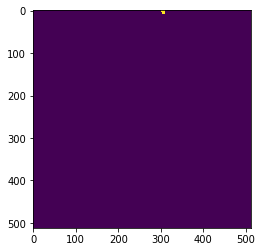

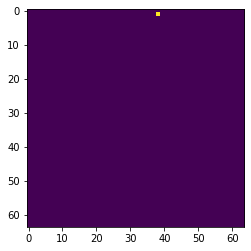

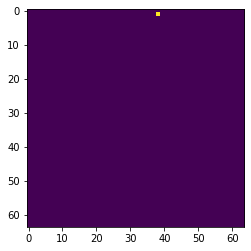

In [13]:
squeezed = np.squeeze(pred_mask)
squeezed_filter = np.where(squeezed>0.5,255,0)
plt.figure(); plt.imshow(squeezed_filter)
cnts = cv.findContours(squeezed_filter.astype(np.uint8), cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)[0]
print(len(cnts))
#drawed = np.zeros((512,512))
for c in cnts:
    drawed = cv.drawContours(np.zeros((64,64)),[c//8],-1,255,1)
drawed[0,:] = 0; drawed[-1,:] = 0; drawed[:,0] = 0 ; drawed[:,-1] = 0
plt.figure(); plt.imshow(drawed)
plt.figure(); plt.imshow(cv.resize(drawed,(64,64),cv.INTER_CUBIC))

25 4
32 4
33 4
30 5
32 5
33 5
30 6
31 6
34 6
6 7
9 8
26 8
25 10
34 10
26 12
31 12
26 13
29 13
30 13
29 14
25 15


/home/centos/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


28 15
32 15
32 16
34 16
26 17
27 17


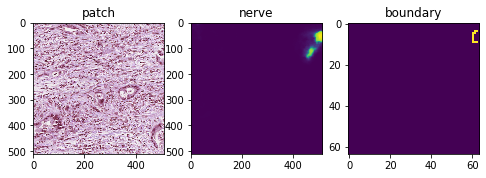

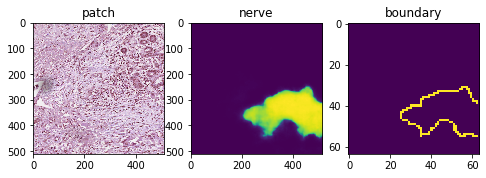

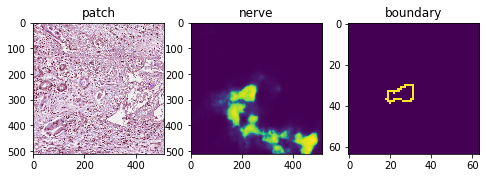

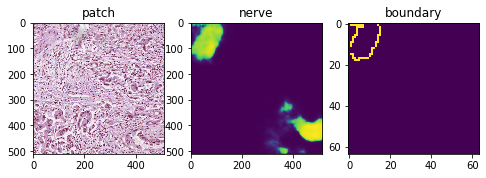

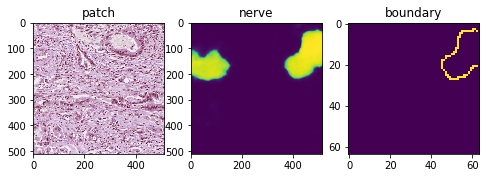

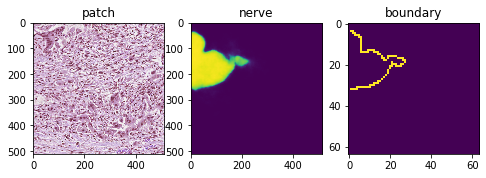

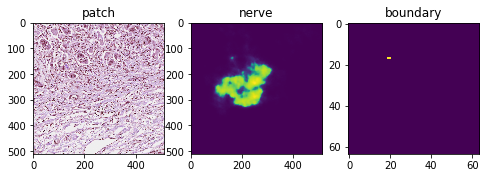

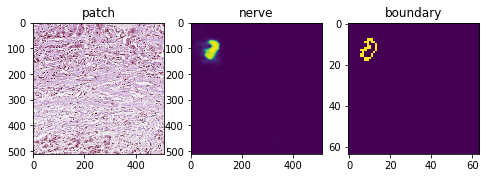

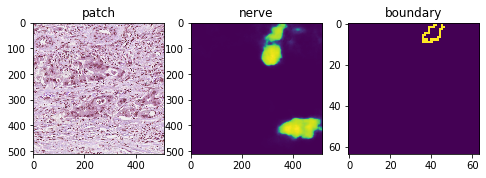

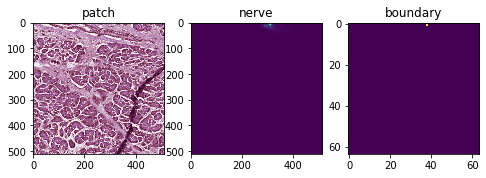

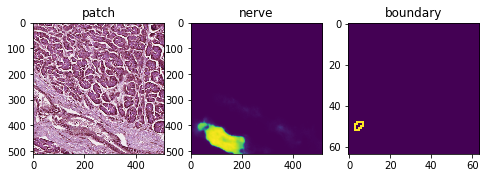

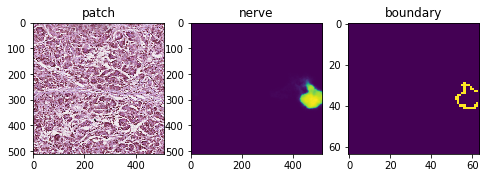

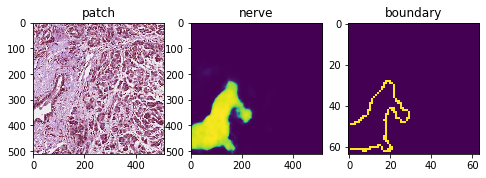

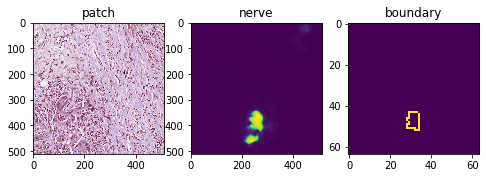

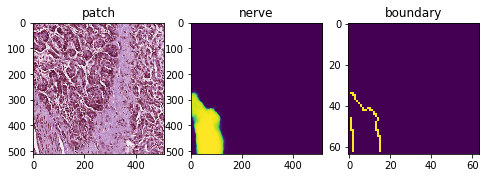

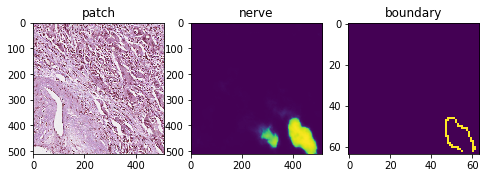

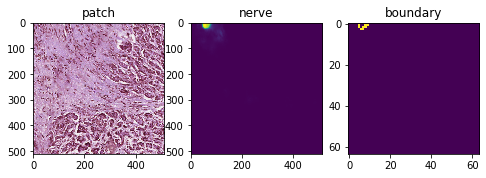

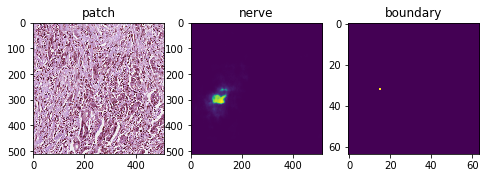

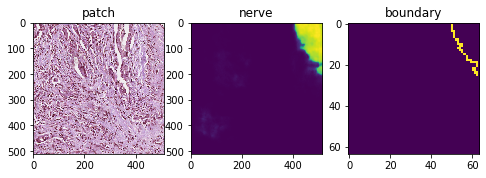

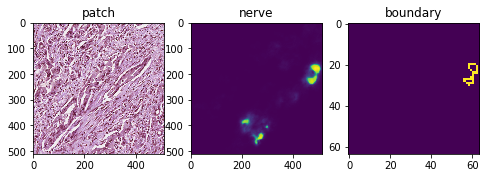

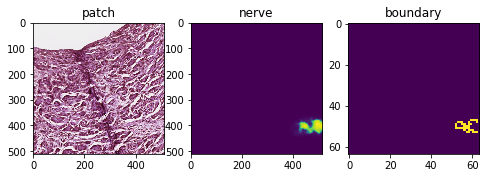

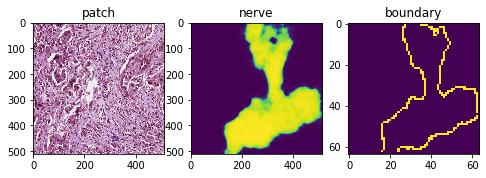

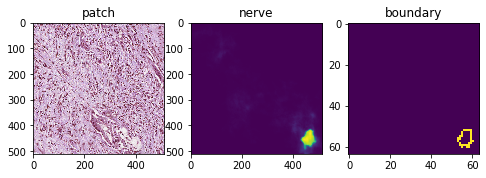

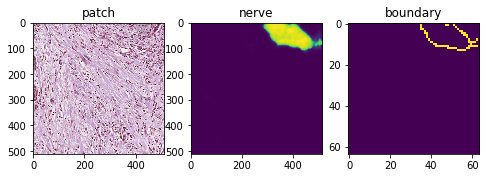

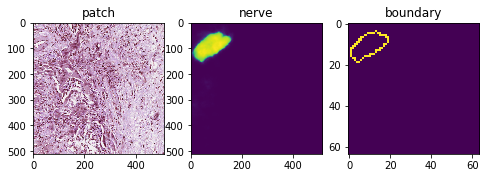

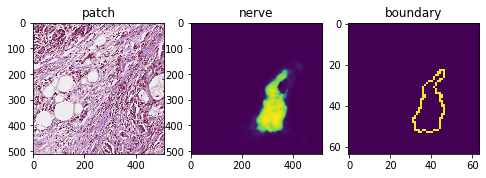

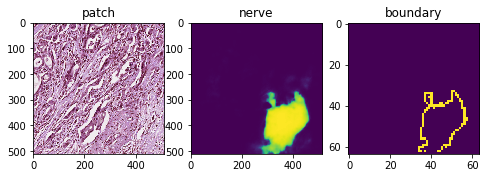

In [16]:
mask = np.zeros((slide.dest_h,slide.dest_w))
for y in y_seq:
    for x in x_seq:
        start_x = int(min_x+(s*x/multiple)); end_x = int(min_x+((s*(x+int(1/step)))/multiple))
        start_y = int(min_y+(s*y/multiple)); end_y = int(min_y+((s*(y+int(1/step)))/multiple))        
        img_patch = np.array(slide.slide.read_region(
            location=(int((min_x*multiple)+(s*x)),
                      int((min_y*multiple)+(s*y))),
            level=0, size = (patch_size_lv0,patch_size_lv0)   
        )).astype(np.uint8)[...,:3]
        img_patch_resized = cv.resize(img_patch,(IMAGE_SIZE,IMAGE_SIZE),cv.INTER_CUBIC)
        img_patch_rgb = cv.cvtColor(img_patch_resized,cv.COLOR_BGR2RGB)
        # clf 
        patch_input = np.expand_dims(img_patch_rgb,axis=0)
        patch_label = clf_mdl.predict(patch_input.astype(np.float32)/255.0)
        #print(pred_patch)
        if patch_label>0.5:
            pred_mask = np.squeeze(seg_mdl.predict(patch_input))
            pred_mask_filter = np.where(pred_mask>0.5,255,0)
            cnts = cv.findContours(pred_mask_filter.astype(np.uint8), cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)[0]
            if len(cnts)>0:
                print(x,y)
                plt.figure(figsize = (8,6))
                plt.subplot(1,3,1); plt.title('patch'); plt.imshow(img_patch_rgb)
                plt.subplot(1,3,2); plt.title('nerve'); plt.imshow(pred_mask)
                for c in cnts:
                    pred_mask = cv.drawContours(np.zeros((end_x-start_x,end_y-start_y)),[c//8],-1,255,1)
                pred_mask[0,:] = 0; pred_mask[-1,:] = 0; pred_mask[:,0] = 0 ; pred_mask[:,-1] = 0
                plt.subplot(1,3,3); plt.title('boundary') ;plt.imshow(pred_mask)
            else:
                pred_mask = np.zeros((end_y-start_y,end_x-start_x))

        else:
            pred_mask = np.zeros((end_y-start_y,end_x-start_x))
        try:
            #mask[start_y:end_y,start_x:end_x] = cv.resize(pred_mask,(end_x-start_x,end_y-start_y),cv.INTER_CUBIC)
            mask[start_y:end_y,start_x:end_x] = pred_mask
        except:
            mask[start_y:end_y,start_x:end_x] = 0
#cv.imwrite(save_path,mask)

## INFERENCE ALL

In [17]:
for fpath in TEST_PATIENT_PATH:
    tissue_name,patient_num = fpath.split('/')[-2:]
    svs_path = glob.glob(f'/home/centos/data/paip/{tissue_name}/*_{patient_num}.svs')[0]
    init_params.update(
        {
            #'svs_path':svs_path,
            'svs_path':svs_path,
            'xml_path':svs_path[:-3]+'xml'

        }
    )
    filename = svs_path.split('/')[-1][:-4]; save_dir = './results_dir/'
    save_path = save_dir + filename + '.tif'
    print(save_path)
    ## SLIDE CALL
    slide = processor(init_params)
    slide.slide.get_thumbnail(size=(400,400))
    ## INIT
    tissue_mask = slide.get_tissue_mask()
    mask = np.zeros((slide.dest_h,slide.dest_w))
    mask_nerve = np.zeros((slide.dest_h,slide.dest_w))
    mask_tumor = np.zeros((slide.dest_h,slide.dest_w))
    print(mask.shape,mask_nerve.shape,mask_tumor.shape)
    counter = np.zeros_like(mask)
    tissue_mask = cv.morphologyEx(tissue_mask,cv.MORPH_OPEN,cv.getStructuringElement(cv.MORPH_RECT,(5,5)),iterations=2)
    anno_mask = slide.get_anno_mask()
    ## SLIDING WINDOW SET
    min_y , min_x = slide.arr.shape[:2]
    max_x , max_y = (0,0)

    coord = np.where(tissue_mask>0)
    if np.min(coord[1])<min_x: min_x = np.min(coord[1])
    if np.max(coord[1])>max_x: max_x = np.max(coord[1])
    if np.min(coord[0])<min_y: min_y = np.min(coord[0])
    if np.max(coord[0])>max_y: max_y = np.max(coord[0])

    ## Sliding tqdm
    slide_w = max_x-min_x; slide_h = max_y-min_y; step = 0.5; multiple = slide.src_h//slide.dest_h
    patch_size = 512; patch_size_lv0 = 2*patch_size;  patch_size_lv2 = patch_size_lv0//multiple
    
    print(f'MIN_X : {min_x} MIN_Y : {min_y} MAX_X : {max_x} MAX_Y : {max_y}')
    print(f'PATCH_0_SIZE : {patch_size_lv0} PATCH_2_SIZE : {patch_size_lv2} ')
    s = int(patch_size_lv0*step)
    y_seq,x_seq = slide.get_seq_range(slide_w,slide_h,multiple,patch_size_lv0,s)
    
    for y in y_seq:
        for x in x_seq:
            start_x = int(min_x+(s*x/multiple)); end_x = int(min_x+((s*(x+int(1/step)))/multiple))
            start_y = int(min_y+(s*y/multiple)); end_y = int(min_y+((s*(y+int(1/step)))/multiple))        
            pred_nerve = np.zeros((end_y-start_y,end_x-start_x))
            pred_tumor = np.zeros((end_y-start_y,end_x-start_x))
            img_patch = np.array(slide.slide.read_region(
                location=(int((min_x*multiple)+(s*x)),
                          int((min_y*multiple)+(s*y))),
                level=0, size = (patch_size_lv0,patch_size_lv0)   
            )).astype(np.uint8)[...,:3]
            img_patch_resized = cv.resize(img_patch,(IMAGE_SIZE,IMAGE_SIZE),cv.INTER_CUBIC)
            img_patch_rgb = cv.cvtColor(img_patch_resized,cv.COLOR_BGR2RGB)
            perineural = anno_mask['p_2'][start_y:end_y,start_x:end_x]

            if slide.get_ratio_mask(tissue_mask[start_y:end_y,start_x:end_x])>0.7: # tissue ratio가 70% 이상인 patch
                # classification
                patch_input = np.expand_dims(img_patch_rgb,axis=0)
                patch_label = clf_mdl.predict(patch_input.astype(np.float32)/255.0)

                if patch_label>0.5 : # 분류결과가 tumor인 patch
                    pred_nerve = np.squeeze(seg_mdl.predict(patch_input/255.0))
                    #pred_nerve_filter = np.where(pred_nerve>0.5,255,0)
                    pred_tumor = np.squeeze(seg_tumor_mdl.predict(patch_input/255.0))
                    pred_nerve=cv.resize(pred_nerve,(end_x-start_x,end_y-start_y))
                    pred_tumor=cv.resize(pred_tumor,(end_x-start_x,end_y-start_y))
                    '''
                    plt.figure();
                    plt.subplot(1,3,1); plt.title('image') ; plt.imshow(img_patch_rgb)
                    plt.subplot(1,3,2); plt.title('answer') ; plt.imshow(perineural)
                    plt.subplot(1,3,3); plt.title('nerve') ; plt.imshow(pred_nerve)
                    '''
                else:
                    pass
            try:
                #mask[start_y:end_y,start_x:end_x] = cv.resize(pred_mask,(end_x-start_x,end_y-start_y),cv.INTER_CUBIC)
                mask_nerve[start_y:end_y,start_x:end_x] = np.where(pred_nerve>mask_nerve[start_y:end_y,start_x:end_x],pred_nerve,mask_nerve[start_y:end_y,start_x:end_x])
                mask_tumor[start_y:end_y,start_x:end_x] = np.where(pred_tumor>mask_tumor[start_y:end_y,start_x:end_x],pred_tumor,mask_tumor[start_y:end_y,start_x:end_x])
            except:
                mask_nerve[start_y:end_y,start_x:end_x] = 0
                mask_tumor[start_y:end_y,start_x:end_x] = 0
    mask_nerve_filtered = np.where(mask_nerve>0.5,255,0)
    mask_tumor_filtered = np.where(mask_tumor>0.5,255,0)
    nerve_cnts = cv.findContours(mask_nerve_filtered.astype(np.uint8), cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)[0]
    print(len(nerve_cnts))
    if len(nerve_cnts)>0:
        for c in nerve_cnts:
            mask = cv.drawContours(mask,[c],-1,1,1)

    tumor_dilated = cv.dilate(mask_tumor_filtered.astype(np.uint8),cv.getStructuringElement(cv.MORPH_RECT,(12,12)),iterations=8)
    mask = np.logical_and(mask,tumor_dilated)
    cv.imwrite(save_path,mask.astype(np.uint8))
    print('1 Completed')

./results_dir/Pros_PNI2021chall_train_0024.tif
(2914, 3983) (2914, 3983) (2914, 3983)


  0%|          | 0/86 [00:00<?, ?it/s]

MIN_X : 122 MIN_Y : 93 MAX_X : 3979 MAX_Y : 2896
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 86/86 [11:36<00:00,  8.10s/it]


9
1 Completed
./results_dir/Pan_PNI2021chall_train_0031.tif
(2963, 3486) (2963, 3486) (2963, 3486)


  0%|          | 0/87 [00:00<?, ?it/s]

MIN_X : 179 MIN_Y : 0 MAX_X : 3215 MAX_Y : 2840
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 87/87 [09:44<00:00,  6.72s/it]


43
1 Completed
./results_dir/Col_PNI2021chall_train_0003.tif


  0%|          | 0/77 [00:00<?, ?it/s]

(2765, 4108) (2765, 4108) (2765, 4108)
MIN_X : 293 MIN_Y : 102 MAX_X : 3958 MAX_Y : 2624
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 77/77 [09:45<00:00,  7.60s/it]


21
1 Completed
./results_dir/Pan_PNI2021chall_train_0036.tif
(2902, 3484) (2902, 3484) (2902, 3484)


  0%|          | 0/89 [00:00<?, ?it/s]

MIN_X : 64 MIN_Y : 15 MAX_X : 3417 MAX_Y : 2901
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 89/89 [12:05<00:00,  8.15s/it]


35
1 Completed
./results_dir/Pan_PNI2021chall_train_0014.tif


  0%|          | 0/67 [00:00<?, ?it/s]

(2403, 2863) (2403, 2863) (2403, 2863)
MIN_X : 156 MIN_Y : 80 MAX_X : 2668 MAX_Y : 2287
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 67/67 [11:08<00:00,  9.98s/it]


52
1 Completed
./results_dir/Pan_PNI2021chall_train_0007.tif
(2582, 3735) (2582, 3735) (2582, 3735)


  0%|          | 0/69 [00:00<?, ?it/s]

MIN_X : 219 MIN_Y : 225 MAX_X : 3558 MAX_Y : 2478
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 69/69 [14:09<00:00, 12.32s/it]


44
1 Completed
./results_dir/Pros_PNI2021chall_train_0021.tif
(2914, 2365) (2914, 2365) (2914, 2365)


  0%|          | 0/89 [00:00<?, ?it/s]

MIN_X : 245 MIN_Y : 0 MAX_X : 2364 MAX_Y : 2895
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 89/89 [15:38<00:00, 10.55s/it]


142
1 Completed
./results_dir/Pros_PNI2021chall_train_0034.tif
(2914, 3983) (2914, 3983) (2914, 3983)


  0%|          | 0/86 [00:00<?, ?it/s]

MIN_X : 88 MIN_Y : 84 MAX_X : 3976 MAX_Y : 2888
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 86/86 [15:42<00:00, 10.95s/it]


150
1 Completed
./results_dir/Pros_PNI2021chall_train_0006.tif
(2904, 3859) (2904, 3859) (2904, 3859)


  0%|          | 0/89 [00:00<?, ?it/s]

MIN_X : 214 MIN_Y : 0 MAX_X : 3591 MAX_Y : 2900
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 89/89 [16:32<00:00, 11.16s/it]


47
1 Completed
./results_dir/Pros_PNI2021chall_train_0009.tif
(2579, 3361) (2579, 3361) (2579, 3361)


  0%|          | 0/72 [00:00<?, ?it/s]

MIN_X : 113 MIN_Y : 103 MAX_X : 3223 MAX_Y : 2468
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 72/72 [12:30<00:00, 10.42s/it]


76
1 Completed
./results_dir/Pan_PNI2021chall_train_0019.tif


  0%|          | 0/55 [00:00<?, ?it/s]

(2016, 2489) (2016, 2489) (2016, 2489)
MIN_X : 116 MIN_Y : 87 MAX_X : 2401 MAX_Y : 1903
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 55/55 [09:23<00:00, 10.25s/it]


113
1 Completed
./results_dir/Col_PNI2021chall_train_0026.tif


  0%|          | 0/73 [00:00<?, ?it/s]

(2938, 3823) (2938, 3823) (2938, 3823)
MIN_X : 220 MIN_Y : 521 MAX_X : 3609 MAX_Y : 2897
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 73/73 [13:55<00:00, 11.45s/it]


106
1 Completed
./results_dir/Col_PNI2021chall_train_0038.tif
(2936, 6349) (2936, 6349) (2936, 6349)


  0%|          | 0/81 [00:00<?, ?it/s]

MIN_X : 1567 MIN_Y : 69 MAX_X : 4095 MAX_Y : 2708
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 81/81 [09:34<00:00,  7.10s/it]


71
1 Completed
./results_dir/Pros_PNI2021chall_train_0045.tif


  0%|          | 0/63 [00:00<?, ?it/s]

(2280, 3361) (2280, 3361) (2280, 3361)
MIN_X : 92 MIN_Y : 101 MAX_X : 3291 MAX_Y : 2169
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 63/63 [08:29<00:00,  8.09s/it]


15
1 Completed
./results_dir/Col_PNI2021chall_train_0006.tif
(2936, 6349) (2936, 6349) (2936, 6349)


  0%|          | 0/62 [00:00<?, ?it/s]

MIN_X : 1256 MIN_Y : 298 MAX_X : 4095 MAX_Y : 2314
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 62/62 [10:37<00:00, 10.29s/it]


45
1 Completed
./results_dir/Col_PNI2021chall_train_0028.tif
(2936, 6349) (2936, 6349) (2936, 6349)


  0%|          | 0/89 [00:00<?, ?it/s]

MIN_X : 599 MIN_Y : 33 MAX_X : 3982 MAX_Y : 2935
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 89/89 [12:51<00:00,  8.67s/it]


27
1 Completed
./results_dir/Col_PNI2021chall_train_0007.tif
(2936, 6349) (2936, 6349) (2936, 6349)


  0%|          | 0/74 [00:00<?, ?it/s]

MIN_X : 673 MIN_Y : 208 MAX_X : 4095 MAX_Y : 2629
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 74/74 [07:39<00:00,  6.20s/it]


0
1 Completed
./results_dir/Col_PNI2021chall_train_0022.tif
(2993, 6723) (2993, 6723) (2993, 6723)


  0%|          | 0/90 [00:00<?, ?it/s]

MIN_X : 0 MIN_Y : 51 MAX_X : 4095 MAX_Y : 2992
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 90/90 [12:58<00:00,  8.65s/it]


22
1 Completed
./results_dir/Pros_PNI2021chall_train_0011.tif
(2713, 3734) (2713, 3734) (2713, 3734)


  0%|          | 0/80 [00:00<?, ?it/s]

MIN_X : 160 MIN_Y : 0 MAX_X : 3650 MAX_Y : 2599
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 80/80 [14:22<00:00, 10.78s/it]


33
1 Completed
./results_dir/Pros_PNI2021chall_train_0041.tif
(2734, 3236) (2734, 3236) (2734, 3236)


  0%|          | 0/80 [00:00<?, ?it/s]

MIN_X : 105 MIN_Y : 23 MAX_X : 3120 MAX_Y : 2626
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 80/80 [11:37<00:00,  8.71s/it]


36
1 Completed
./results_dir/Pros_PNI2021chall_train_0003.tif


  0%|          | 0/67 [00:00<?, ?it/s]

(2465, 2863) (2465, 2863) (2465, 2863)
MIN_X : 112 MIN_Y : 164 MAX_X : 2756 MAX_Y : 2355
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 67/67 [12:49<00:00, 11.49s/it]


194
1 Completed
./results_dir/Pros_PNI2021chall_train_0018.tif
(2728, 3485) (2728, 3485) (2728, 3485)


  0%|          | 0/84 [00:00<?, ?it/s]

MIN_X : 262 MIN_Y : 0 MAX_X : 3470 MAX_Y : 2723
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 84/84 [23:56<00:00, 17.10s/it]


198
1 Completed
./results_dir/Col_PNI2021chall_train_0049.tif


  0%|          | 0/82 [00:00<?, ?it/s]

(2873, 3361) (2873, 3361) (2873, 3361)
MIN_X : 106 MIN_Y : 16 MAX_X : 3179 MAX_Y : 2680
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 82/82 [11:19<00:00,  8.29s/it]


38
1 Completed
./results_dir/Col_PNI2021chall_train_0043.tif


  0%|          | 0/86 [00:00<?, ?it/s]

(2914, 3361) (2914, 3361) (2914, 3361)
MIN_X : 173 MIN_Y : 0 MAX_X : 3213 MAX_Y : 2813
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 86/86 [14:36<00:00, 10.19s/it]


82
1 Completed
./results_dir/Pan_PNI2021chall_train_0039.tif
(2937, 4272) (2937, 4272) (2937, 4272)


  0%|          | 0/90 [00:00<?, ?it/s]

MIN_X : 240 MIN_Y : 0 MAX_X : 4085 MAX_Y : 2936
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 90/90 [22:51<00:00, 15.24s/it]


32
1 Completed
./results_dir/Pan_PNI2021chall_train_0005.tif
(2902, 3857) (2902, 3857) (2902, 3857)


  0%|          | 0/87 [00:00<?, ?it/s]

MIN_X : 0 MIN_Y : 0 MAX_X : 3673 MAX_Y : 2832
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 87/87 [12:14<00:00,  8.44s/it]


22
1 Completed
./results_dir/Pan_PNI2021chall_train_0037.tif
(2938, 4048) (2938, 4048) (2938, 4048)


  0%|          | 0/90 [00:00<?, ?it/s]

MIN_X : 110 MIN_Y : 0 MAX_X : 3845 MAX_Y : 2937
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 90/90 [21:16<00:00, 14.18s/it]


45
1 Completed
./results_dir/Pros_PNI2021chall_train_0049.tif
(2512, 3236) (2512, 3236) (2512, 3236)


  0%|          | 0/72 [00:00<?, ?it/s]

MIN_X : 120 MIN_Y : 72 MAX_X : 3124 MAX_Y : 2408
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 72/72 [14:00<00:00, 11.67s/it]


116
1 Completed
./results_dir/Pan_PNI2021chall_train_0035.tif
(2901, 3857) (2901, 3857) (2901, 3857)


  0%|          | 0/89 [00:00<?, ?it/s]

MIN_X : 88 MIN_Y : 0 MAX_X : 3826 MAX_Y : 2900
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 89/89 [18:19<00:00, 12.35s/it]


132
1 Completed
./results_dir/Pan_PNI2021chall_train_0033.tif
(2935, 3734) (2935, 3734) (2935, 3734)


  0%|          | 0/90 [00:00<?, ?it/s]

MIN_X : 102 MIN_Y : 0 MAX_X : 3671 MAX_Y : 2934
PATCH_0_SIZE : 1024 PATCH_2_SIZE : 64 


100%|██████████| 90/90 [16:26<00:00, 10.96s/it]


38
1 Completed


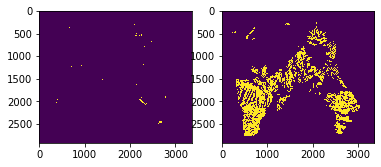

In [8]:
mask_nerve_filtered = np.where(mask_nerve>0.5,255,0)
mask_tumor_filtered = np.where(mask_tumor>0.5,255,0)
plt.subplot(1,2,1);plt.imshow(mask_nerve_filtered)
plt.subplot(1,2,2);plt.imshow(mask_tumor_filtered)

In [12]:
nerve_cnts = cv.findContours(mask_nerve_filtered.astype(np.uint8), cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)[0]
print(len(nerve_cnts))
if len(nerve_cnts)>0:
    for c in nerve_cnts:
        mask = cv.drawContours(mask,[c],-1,1,1)

tumor_dilated = cv.dilate(mask_tumor_filtered.astype(np.uint8),cv.getStructuringElement(cv.MORPH_RECT,(12,12)),iterations=8)
mask = np.logical_and(mask,tumor_dilated)

82


In [14]:
cv.imwrite(save_path,mask.astype(np.uint8))

True

In [34]:
np.maximum(a,b)

array([[0.  , 0.75],
       [0.5 , 0.5 ]])

In [55]:
np.where(a>b,a,b)

array([[0.  , 0.75],
       [0.5 , 0.5 ]])

array([[0.1 , 0.75, 0.  , 0.  ],
       [0.1 , 0.5 , 0.  , 0.  ]])

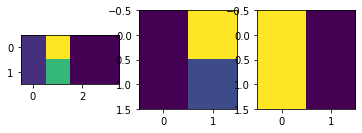

In [68]:
msk = np.zeros((2,4))
a = np.array(((0.1,0.75),(0.1,0.25)))
b = np.array(((0.5,0.0),(0.5,0.0)))
c = np.array(((0.0,0.0),(0.0,0.0)))
#for i in range(2):
    #msk[:,i:i+2]=(msk[:,i:i+2]+a)/2
    #msk[:,i:i+2] = np.maximum(msk[:,i:i+2],a)
    
msk[:,0:2] = np.where(a>msk[:,0:2],a,msk[:,0:2])
msk[:,1:3] = np.where(b>msk[:,1:3],b,msk[:,1:3])
msk[:,2:4] = np.where(c>msk[:,2:4],c,msk[:,2:4])

plt.subplot(1,3,1); plt.imshow(msk)
plt.subplot(1,3,2); plt.imshow(a)
plt.subplot(1,3,3); plt.imshow(b)
msk

In [40]:
for y in y_seq:
    for x in x_seq:
        start_x = int(min_x+(s*x/multiple)); end_x = int(min_x+((s*(x+int(1/step)))/multiple))
        start_y = int(min_y+(s*y/multiple)); end_y = int(min_y+((s*(y+int(1/step)))/multiple))        
        img_patch = np.array(slide.slide.read_region(
            location=(int((min_x*multiple)+(s*x)),
                      int((min_y*multiple)+(s*y))),
            level=0, size = (patch_size_lv0,patch_size_lv0)   
        )).astype(np.uint8)[...,:3]
        img_patch_resized = cv.resize(img_patch,(IMAGE_SIZE,IMAGE_SIZE),cv.INTER_CUBIC)
        img_patch_rgb = cv.cvtColor(img_patch_resized,cv.COLOR_BGR2RGB)
        perineural = anno_mask['p_2'][start_y:end_y,start_x:end_x]
        
        if slide.get_ratio_mask(tissue_mask[start_y:end_y,start_x:end_x])>0.7: # tissue ratio가 70% 이상인 patch
            # classification
            patch_input = np.expand_dims(img_patch_rgb,axis=0)
            patch_label = clf_mdl.predict(patch_input.astype(np.float32)/255.0)

            if patch_label>0.5 : # 분류결과가 tumor인 patch
                pred_nerve = np.squeeze(seg_mdl.predict(patch_input/255.0))
                #pred_nerve_filter = np.where(pred_nerve>0.5,255,0)
                pred_tumor = np.squeeze(seg_tumor_mdl.predict(patch_input/255.0))
                pred_nerve=cv.resize(pred_nerve,(end_x-start_x,end_y-start_y))
                pred_tumor=cv.resize(pred_tumor,(end_x-start_x,end_y-start_y))
            else:
                pred_nerve = np.zeros((end_y-start_y,end_x-start_x))
                pred_tumor = np.zeros((end_y-start_y,end_x-start_x))
        try:
            #mask[start_y:end_y,start_x:end_x] = cv.resize(pred_mask,(end_x-start_x,end_y-start_y),cv.INTER_CUBIC)
            mask_nerve[start_y:end_y,start_x:end_x] = np.maximum(mask_nerve[start_y:end_y,start_x:end_x],pred_nerve)
            mask_tumor[start_y:end_y,start_x:end_x] = np.maximum(mask_tumor[start_y:end_y,start_x:end_x],pred_nerve)
        except:
            mask[start_y:end_y,start_x:end_x] = 0
#cv.imwrite(save_path,mask.astype(np.uint8))

  0%|          | 0/93 [49:12<?, ?it/s]


KeyboardInterrupt: 